# Project code

gg

In [1]:
import os
from pathlib import Path
import time

import cv2
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.random_projection import GaussianRandomProjection
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import tensorly as tl
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision.datasets import EMNIST
from torch.utils.data import Dataset, random_split
from torchvision import datasets
from torchvision.transforms import v2

import utils

## Data loading utilities

In [2]:
# this dataset is already random rotated
handiso_ds_train = utils.CharDataset("data/handwritten-isolated-english/train")
handiso_ds_test = utils.CharDataset("data/handwritten-isolated-english/test")
handiso_test_data, handiso_test_labels = utils.ds_to_vectors(handiso_ds_test)

notmnist_ds = utils.CharDataset("data/notMNIST_small", transform=utils.T_randrot)
notmnist_ds_train, notmnist_ds_test = random_split(notmnist_ds, [0.8, 0.2])
notmnist_test_data, notmnist_test_labels = utils.ds_to_vectors(notmnist_ds_test)

stdocr_ds_train_orig = (
    utils.CharDataset("data/standard_ocr_dataset/data/training_data", transform=utils.T_randrot) +
    utils.CharDataset("data/standard_ocr_dataset/data2/training_data", transform=utils.T_randrot)
)
stdocr_ds_test = (
    utils.CharDataset("data/standard_ocr_dataset/data/testing_data", transform=utils.T_randrot) + 
    utils.CharDataset("data/standard_ocr_dataset/data2/testing_data", transform=utils.T_randrot)
)
stdocr_test_data, stdocr_test_labels = utils.ds_to_vectors(stdocr_ds_test)

mnist_ds_train_letters = EMNIST(Path(os.getcwd(), "data"), "letters", download=True, train=True, transform=utils.T_randrot, target_transform=utils.emnistletter_idx_to_class)
mnist_ds_train_digits = EMNIST(Path(os.getcwd(), "data"), "digits", download=True, train=True, transform=utils.T_randrot, target_transform=utils.emnistdigit_idx_to_class)
mnist_ds_train_orig = mnist_ds_train_letters + mnist_ds_train_digits
mnist_ds_test_letters = EMNIST(Path(os.getcwd(), "data"), "letters", download=True, train=False, transform=utils.T_randrot, target_transform=utils.emnistletter_idx_to_class)
mnist_ds_test_digits = EMNIST(Path(os.getcwd(), "data"), "digits", download=True, train=False, transform=utils.T_randrot, target_transform=utils.emnistdigit_idx_to_class)
mnist_ds_test_orig = mnist_ds_test_letters + mnist_ds_test_digits

Image data\notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png is not a valid image, skipping
Image data\notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png is not a valid image, skipping
Image data\standard_ocr_dataset\data2\testing_data\G\44404.png is not a valid image, skipping


In [3]:
print(f"handwritten-isolated-english sizes: [train:{len(handiso_ds_train)}, test:{len(handiso_ds_test)}]")
print(f"not MNIST sizes: [train:{len(notmnist_ds_train)}, test:{len(notmnist_ds_test)}]")
print(f"standard OCR ds sizes: [train:{len(stdocr_ds_train_orig)}, test:{len(stdocr_ds_test)}]")
print(f"EMNIST sizes: [train:{len(mnist_ds_train_orig)}, test:{len(mnist_ds_test_orig)}]")

handwritten-isolated-english sizes: [train:13168, test:1792]
not MNIST sizes: [train:14980, test:3744]
standard OCR ds sizes: [train:41256, test:4249]
EMNIST sizes: [train:364800, test:60800]


In [4]:
# EMNIST dataset is way too large for our purposes, we only take a subset of it
stdocr_ds_train, _ = random_split(stdocr_ds_train_orig, [0.5, 0.5])
mnist_ds_train, _ = random_split(mnist_ds_train_orig, [0.05, 0.95])
mnist_ds_test, _ = random_split(mnist_ds_test_orig, [0.05, 0.95])
mnist_test_data, mnist_test_labels = utils.ds_to_vectors(mnist_ds_test)

In [5]:
print(f"handwritten-isolated-english sizes: [train:{len(handiso_ds_train)}, test:{len(handiso_ds_test)}]")
print(f"not MNIST sizes: [train:{len(notmnist_ds_train)}, test:{len(notmnist_ds_test)}]")
print(f"standard OCR ds sizes: [train:{len(stdocr_ds_train)}, test:{len(stdocr_ds_test)}]")
print(f"EMNIST sizes: [train:{len(mnist_ds_train)}, test:{len(mnist_ds_test)}]")

handwritten-isolated-english sizes: [train:13168, test:1792]
not MNIST sizes: [train:14980, test:3744]
standard OCR ds sizes: [train:20628, test:4249]
EMNIST sizes: [train:18240, test:3040]


In [6]:
consolidated_ds_train = handiso_ds_train + notmnist_ds_train + stdocr_ds_train + mnist_ds_train
consolidated_ds_test = handiso_ds_test + notmnist_ds_test + stdocr_ds_test + mnist_ds_test

In [7]:
cons_train_data, cons_train_labels = utils.ds_to_vectors(consolidated_ds_train)
cons_test_data, cons_test_labels = utils.ds_to_vectors(consolidated_ds_test)

## Utility functions for model setup and testing

In [8]:
def run_all_tests_model(model, data_transform=None):
    if data_transform is None:
        data_transform = lambda x: x
    ts = utils.tic()
    handwrscore = model.score(data_transform(handiso_test_data), handiso_test_labels)
    notmnistscore = model.score(data_transform(notmnist_test_data), notmnist_test_labels)
    stdocrscore = model.score(data_transform(stdocr_test_data), stdocr_test_labels)
    mnistscore = model.score(data_transform(mnist_test_data), mnist_test_labels)
    utils.toc(ts, "Model testing")
    tot_test = len(handiso_test_labels) + len(notmnist_test_labels) + len(stdocr_test_labels) + len(mnist_test_labels)
    weighted_score = (handwrscore * len(handiso_test_labels) + notmnistscore * len(notmnist_test_labels) + stdocrscore * len(stdocr_test_labels) + mnistscore * len(mnist_test_labels)) / tot_test
    print(f"handwritten-isolated score: {handwrscore}\n"
          f"notMNIST score: {notmnistscore}\n"
          f"standard OCR score: {stdocrscore}\n"
          f"EMNIST score: {mnistscore}\n"
          f"Aggregate score: {weighted_score}")
    return handwrscore, notmnistscore, stdocrscore, mnistscore, weighted_score

def test_trf_models(create_model_func, trf_funcs, mincomps, maxcomps):
    """
    create_model_func: (X, y, data_transform=func) -> scipy classification model
    """
    assert len(trf_funcs) == (maxcomps + 1) - mincomps
    handwrscores, notmnistscores, stdocrscores, mnistscores, aggscores = [], [], [], [], []
    traintimes, predicttimes = [], []
    for ncomp in range(mincomps, maxcomps + 1):
        print(f"n_components: {ncomp}")
        trf = trf_funcs[ncomp - mincomps]
        ts = utils.tic()
        consol_model = create_model_func(cons_train_data, cons_train_labels, data_transform=trf)
        traintimes.append(utils.toc(ts, printtime=False))
        ts = utils.tic()
        handwrscore, notmnistscore, stdocrscore, mnistscore, aggscore = run_all_tests_model(consol_model, data_transform=trf)
        predicttimes.append(utils.toc(ts, printtime=False))
        handwrscores.append(handwrscore)
        notmnistscores.append(notmnistscore)
        stdocrscores.append(stdocrscore)
        mnistscores.append(mnistscore)
        aggscores.append(aggscore)
        print("------")
    return {
        "handwrscores": handwrscores,
        "notmnistscores": notmnistscores,
        "stdocrscores": stdocrscores,
        "mnistscores": mnistscores,
        "aggscores": aggscores,
        "traintimes": traintimes,
        "predicttimes": predicttimes
    }

def plot_scores(results, ncomplist, title="Classification results for dimensionality reduction"):
    fig, ax = plt.subplots()
    ax.plot(ncomplist, results["handwrscores"], "-", label="handwritten-isolated")
    ax.plot(ncomplist, results["notmnistscores"], "-", label="notMNIST")
    ax.plot(ncomplist, results["stdocrscores"], "-", label="standard OCR")
    ax.plot(ncomplist, results["mnistscores"], "-", label="EMNIST")
    ax.plot(ncomplist, results["aggscores"], "--", label="aggregated")
    ax.set_xlabel("number of components")
    ax.set_ylabel("test accuracy")
    ax.legend()
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

In [9]:
def create_logreg(X, y, data_transform=None):
    if data_transform is None:
        data_transform = lambda x: x
    ts = utils.tic()
    logreg = LogisticRegression()
    logreg.fit(data_transform(X), y)
    utils.toc(ts, "Logistic Regression training")
    return logreg

def create_knn(X, y, k=5, data_transform=None):
    if data_transform is None:
        data_transform = lambda x: x
    ts = utils.tic()
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(data_transform(X), y)
    utils.toc(ts, "KNN training")
    return knn

In [10]:
def create_svm(X,y,decision_function='ovr',data_transform=None):
    if data_transform is None:
        data_transform = lambda x: x
    ts = utils.tic()
    svm = SVC(decision_function_shape=decision_function)
    svm.fit(data_transform(X),y)
    utils.toc(ts, "SVM training")
    return svm

def create_mlp(X,y,hidden_layer=100,activation='relu',data_transform=None):
    if data_transform is None:
        data_transform = lambda x: x
    ts = utils.tic()
    MLP = MLPClassifier()
    MLP.fit(data_transform(X),y)
    utils.toc(ts, "MLP training")
    return MLP

## Raw model tests

In [11]:
# logistic regression linear classifier
consol_logreg = create_logreg(cons_train_data, cons_train_labels)
run_all_tests_model(consol_logreg)

Logistic Regression training took: 15.54787015914917 sec.

Model testing took: 0.041042327880859375 sec.

handwritten-isolated score: 0.04743303571428571
notMNIST score: 0.5841346153846154
standard OCR score: 0.4356319133913862
EMNIST score: 0.4444078947368421
Aggregate score: 0.42682261208577


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.04743303571428571,
 0.5841346153846154,
 0.4356319133913862,
 0.4444078947368421,
 0.42682261208577)

In [12]:
# KNN classifier
consol_knn = create_knn(cons_train_data, cons_train_labels, k=5)
run_all_tests_model(consol_knn)

KNN training took: 0.01149439811706543 sec.



Model testing took: 25.35016417503357 sec.

handwritten-isolated score: 0.6037946428571429
notMNIST score: 0.7922008547008547
standard OCR score: 0.8879736408566722
EMNIST score: 0.6960526315789474
Aggregate score: 0.7748148148148148


(0.6037946428571429,
 0.7922008547008547,
 0.8879736408566722,
 0.6960526315789474,
 0.7748148148148148)

In [13]:
#SVM classifier
# consol_svm = create_svm(cons_train_data, cons_train_labels)
# run_all_tests_model(consol_svm)

In [20]:
#saved svm from whole data, save some run time.
import pickle
# with open('trained_svm','wb') as f:
#     pickle.dump(consol_svm,f)

with open('trained_svm','rb') as f:
    consol_svm=pickle.load(f)

run_all_tests_model(consol_svm)

Model testing took: 477.21545219421387 sec.

handwritten-isolated score: 0.11774553571428571
notMNIST score: 0.8731303418803419
standard OCR score: 0.9364556366203812
EMNIST score: 0.7101973684210526
Aggregate score: 0.7499415204678362


(0.11774553571428571,
 0.8731303418803419,
 0.9364556366203812,
 0.7101973684210526,
 0.7499415204678362)

In [15]:
#MLP classifier
# consol_mlp = create_mlp(cons_train_data,cons_train_labels,hidden_layer=500)
# run_all_tests_model(consol_mlp)

In [21]:
#saved mlp from whole data, save some run time.
import pickle
# with open('trained_mlp','wb') as f:
#     pickle.dump(consol_mlp,f)

with open('trained_mlp','rb') as f:
    consol_mlp=pickle.load(f)

run_all_tests_model(consol_mlp)

Model testing took: 0.9297041893005371 sec.

handwritten-isolated score: 0.04241071428571429
notMNIST score: 0.5873397435897436
standard OCR score: 0.32572369969404563
EMNIST score: 0.48651315789473687
Aggregate score: 0.40062378167641327


(0.04241071428571429,
 0.5873397435897436,
 0.32572369969404563,
 0.48651315789473687,
 0.40062378167641327)

## Tests with PCA

In [17]:
def create_pca(X, n_components):
    ts = utils.tic()
    pca = PCA(n_components=n_components)
    pca.fit(X)
    utils.toc(ts, "Creating PCA components")
    return pca

# could probably just initialize PCA with max components first, then just subset the
# eigenvectors, but I'm too lazy to do that
allpcas = [create_pca(cons_train_data, i) for i in range(2, 60)]
pcatrf_funcs = [pca.transform for pca in allpcas]

Creating PCA components took: 0.8823375701904297 sec.

Creating PCA components took: 0.849719762802124 sec.

Creating PCA components took: 0.9414987564086914 sec.

Creating PCA components took: 0.892514705657959 sec.

Creating PCA components took: 0.9066874980926514 sec.

Creating PCA components took: 0.9756386280059814 sec.

Creating PCA components took: 1.0123014450073242 sec.

Creating PCA components took: 1.0684447288513184 sec.

Creating PCA components took: 1.1178669929504395 sec.

Creating PCA components took: 1.093437910079956 sec.

Creating PCA components took: 1.1003367900848389 sec.

Creating PCA components took: 1.1875481605529785 sec.

Creating PCA components took: 1.2118408679962158 sec.

Creating PCA components took: 1.1413516998291016 sec.

Creating PCA components took: 1.141402244567871 sec.

Creating PCA components took: 1.1807377338409424 sec.

Creating PCA components took: 1.159193515777588 sec.

Creating PCA components took: 1.2033326625823975 sec.

Creating PCA co

In [18]:
pcatrf_funcs = [pca.transform for pca in allpcas]

### Logistic regression linear classifier

In [22]:
logreg_pca_results = test_trf_models(create_logreg, pcatrf_funcs, 2, 59)

n_components: 2
Logistic Regression training took: 3.087099075317383 sec.

Model testing took: 0.06879782676696777 sec.

handwritten-isolated score: 0.036830357142857144
notMNIST score: 0.19764957264957264
standard OCR score: 0.015533066603906801
EMNIST score: 0.1118421052631579
Aggregate score: 0.09450292397660819
------
n_components: 3


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.8258585929870605 sec.

Model testing took: 0.0709993839263916 sec.

handwritten-isolated score: 0.048549107142857144
notMNIST score: 0.17895299145299146
standard OCR score: 0.02165215344787009
EMNIST score: 0.15921052631578947
Aggregate score: 0.10393762183235868
------
n_components: 4


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.270670175552368 sec.

Model testing took: 0.07876706123352051 sec.

handwritten-isolated score: 0.04575892857142857
notMNIST score: 0.22542735042735043
standard OCR score: 0.02377029889385738
EMNIST score: 0.1569078947368421
Aggregate score: 0.11727095516569201
------
n_components: 5


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.1842944622039795 sec.

Model testing took: 0.08400154113769531 sec.

handwritten-isolated score: 0.040736607142857144
notMNIST score: 0.29941239316239315
standard OCR score: 0.015533066603906801
EMNIST score: 0.18717105263157896
Aggregate score: 0.1426120857699805
------
n_components: 6


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.411167144775391 sec.

Model testing took: 0.07700061798095703 sec.

handwritten-isolated score: 0.04296875
notMNIST score: 0.4027777777777778
standard OCR score: 0.020946104965874325
EMNIST score: 0.24111842105263157
Aggregate score: 0.1876803118908382
------
n_components: 7


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.094806432723999 sec.

Model testing took: 0.07400035858154297 sec.

handwritten-isolated score: 0.04241071428571429
notMNIST score: 0.41212606837606836
standard OCR score: 0.03671452106377971
EMNIST score: 0.25921052631578945
Aggregate score: 0.19984405458089669
------
n_components: 8


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.558787822723389 sec.

Model testing took: 0.06818437576293945 sec.

handwritten-isolated score: 0.040736607142857144
notMNIST score: 0.48878205128205127
standard OCR score: 0.05624852906566251
EMNIST score: 0.2894736842105263
Aggregate score: 0.23563352826510722
------
n_components: 9


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.737050533294678 sec.

Model testing took: 0.06699538230895996 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.5229700854700855
standard OCR score: 0.07554718757354671
EMNIST score: 0.3134868421052632
Aggregate score: 0.2572319688109162
------
n_components: 10


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.228724956512451 sec.

Model testing took: 0.08600163459777832 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.5344551282051282
standard OCR score: 0.07084019769357495
EMNIST score: 0.32401315789473684
Aggregate score: 0.26214424951267057
------
n_components: 11


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.501720190048218 sec.

Model testing took: 0.07046961784362793 sec.

handwritten-isolated score: 0.040736607142857144
notMNIST score: 0.5502136752136753
standard OCR score: 0.08048952694751706
EMNIST score: 0.3348684210526316
Aggregate score: 0.27235867446393763
------
n_components: 12


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.107003450393677 sec.

Model testing took: 0.07097864151000977 sec.

handwritten-isolated score: 0.040736607142857144
notMNIST score: 0.5432692307692307
standard OCR score: 0.10284772887738292
EMNIST score: 0.3404605263157895
Aggregate score: 0.2790643274853801
------
n_components: 13


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.296263694763184 sec.

Model testing took: 0.0729985237121582 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.5395299145299145
standard OCR score: 0.10614262179336315
EMNIST score: 0.33881578947368424
Aggregate score: 0.2792982456140351
------
n_components: 14


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.159919500350952 sec.

Model testing took: 0.07387900352478027 sec.

handwritten-isolated score: 0.04631696428571429
notMNIST score: 0.5486111111111112
standard OCR score: 0.11390915509531654
EMNIST score: 0.33651315789473685
Aggregate score: 0.2841325536062378
------
n_components: 15


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.174505949020386 sec.

Model testing took: 0.09538006782531738 sec.

handwritten-isolated score: 0.04352678571428571
notMNIST score: 0.5587606837606838
standard OCR score: 0.1301482701812191
EMNIST score: 0.3404605263157895
Aggregate score: 0.2930214424951267
------
n_components: 16


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.789506912231445 sec.

Model testing took: 0.07973003387451172 sec.

handwritten-isolated score: 0.04743303571428571
notMNIST score: 0.5657051282051282
standard OCR score: 0.159331607437044
EMNIST score: 0.3447368421052632
Aggregate score: 0.30627680311890837
------
n_components: 17


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.191111326217651 sec.

Model testing took: 0.07767248153686523 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.5742521367521367
standard OCR score: 0.16992233466698048
EMNIST score: 0.35789473684210527
Aggregate score: 0.31508771929824564
------
n_components: 18


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.09912109375 sec.

Model testing took: 0.0808248519897461 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.5718482905982906
standard OCR score: 0.1809837608849141
EMNIST score: 0.35789473684210527
Aggregate score: 0.31758284600389863
------
n_components: 19


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.82507848739624 sec.

Model testing took: 0.07869338989257812 sec.

handwritten-isolated score: 0.048549107142857144
notMNIST score: 0.5560897435897436
standard OCR score: 0.2080489526947517
EMNIST score: 0.36085526315789473
Aggregate score: 0.3235867446393762
------
n_components: 20


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.971922159194946 sec.

Model testing took: 0.08500480651855469 sec.

handwritten-isolated score: 0.028459821428571428
notMNIST score: 0.5643696581196581
standard OCR score: 0.2471169686985173
EMNIST score: 0.3726973684210526
Aggregate score: 0.3389473684210526
------
n_components: 21


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.010848522186279 sec.

Model testing took: 0.10795402526855469 sec.

handwritten-isolated score: 0.03236607142857143
notMNIST score: 0.5659722222222222
standard OCR score: 0.2551188514944693
EMNIST score: 0.3782894736842105
Aggregate score: 0.34393762183235865
------
n_components: 22


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.379483938217163 sec.

Model testing took: 0.07779097557067871 sec.

handwritten-isolated score: 0.03571428571428571
notMNIST score: 0.5694444444444444
standard OCR score: 0.26570957872440576
EMNIST score: 0.3838815789473684
Aggregate score: 0.35025341130604287
------
n_components: 23


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.225130319595337 sec.

Model testing took: 0.07739925384521484 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.5611645299145299
standard OCR score: 0.2765356554483408
EMNIST score: 0.38421052631578945
Aggregate score: 0.3511890838206628
------
n_components: 24


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.488009929656982 sec.

Model testing took: 0.07847261428833008 sec.

handwritten-isolated score: 0.03962053571428571
notMNIST score: 0.5731837606837606
standard OCR score: 0.27559425747234645
EMNIST score: 0.38552631578947366
Aggregate score: 0.35555555555555557
------
n_components: 25


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.541069984436035 sec.

Model testing took: 0.07890510559082031 sec.

handwritten-isolated score: 0.0390625
notMNIST score: 0.5694444444444444
standard OCR score: 0.2779477524123323
EMNIST score: 0.38717105263157897
Aggregate score: 0.35555555555555557
------
n_components: 26


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.75285267829895 sec.

Model testing took: 0.0780031681060791 sec.

handwritten-isolated score: 0.03962053571428571
notMNIST score: 0.5718482905982906
standard OCR score: 0.2765356554483408
EMNIST score: 0.39769736842105263
Aggregate score: 0.3583625730994152
------
n_components: 27


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.855232000350952 sec.

Model testing took: 0.08506560325622559 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.5697115384615384
standard OCR score: 0.2920687220522476
EMNIST score: 0.39671052631578946
Aggregate score: 0.362962962962963
------
n_components: 28


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.957421064376831 sec.

Model testing took: 0.10375142097473145 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.5713141025641025
standard OCR score: 0.30830783713815013
EMNIST score: 0.3983552631578947
Aggregate score: 0.36920077972709553
------
n_components: 29


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.215593099594116 sec.

Model testing took: 0.0989220142364502 sec.

handwritten-isolated score: 0.040736607142857144
notMNIST score: 0.5742521367521367
standard OCR score: 0.31348552600611906
EMNIST score: 0.39407894736842103
Aggregate score: 0.3706042884990253
------
n_components: 30


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.305097818374634 sec.

Model testing took: 0.0862724781036377 sec.

handwritten-isolated score: 0.04241071428571429
notMNIST score: 0.5739850427350427
standard OCR score: 0.3264297481760414
EMNIST score: 0.4049342105263158
Aggregate score: 0.37762183235867447
------
n_components: 31


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.3444905281066895 sec.

Model testing took: 0.08503532409667969 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.5745192307692307
standard OCR score: 0.33137208755001174
EMNIST score: 0.40592105263157896
Aggregate score: 0.3795711500974659
------
n_components: 32


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.093757629394531 sec.

Model testing took: 0.07863020896911621 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.5758547008547008
standard OCR score: 0.33984466933396096
EMNIST score: 0.4049342105263158
Aggregate score: 0.3830019493177388
------
n_components: 33


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.854533910751343 sec.

Model testing took: 0.08890461921691895 sec.

handwritten-isolated score: 0.04575892857142857
notMNIST score: 0.5731837606837606
standard OCR score: 0.3499646975759002
EMNIST score: 0.4069078947368421
Aggregate score: 0.3861208576998051
------
n_components: 34


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.74778938293457 sec.

Model testing took: 0.0854947566986084 sec.

handwritten-isolated score: 0.04575892857142857
notMNIST score: 0.5793269230769231
standard OCR score: 0.3511414450458932
EMNIST score: 0.4069078947368421
Aggregate score: 0.3883040935672515
------
n_components: 35


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.785774230957031 sec.

Model testing took: 0.08347129821777344 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.5755876068376068
standard OCR score: 0.35278889150388326
EMNIST score: 0.4082236842105263
Aggregate score: 0.3875243664717349
------
n_components: 36


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.502557754516602 sec.

Model testing took: 0.08658313751220703 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.5785256410256411
standard OCR score: 0.35961402682984234
EMNIST score: 0.41118421052631576
Aggregate score: 0.3913450292397661
------
n_components: 37


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.380980968475342 sec.

Model testing took: 0.09101176261901855 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.5790598290598291
standard OCR score: 0.3598493763238409
EMNIST score: 0.4125
Aggregate score: 0.39235867446393763
------
n_components: 38


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.511025667190552 sec.

Model testing took: 0.09197854995727539 sec.

handwritten-isolated score: 0.04017857142857143
notMNIST score: 0.5766559829059829
standard OCR score: 0.36102612379383386
EMNIST score: 0.4085526315789474
Aggregate score: 0.3904093567251462
------
n_components: 39


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.887044668197632 sec.

Model testing took: 0.09043741226196289 sec.

handwritten-isolated score: 0.03962053571428571
notMNIST score: 0.5809294871794872
standard OCR score: 0.36714521063779715
EMNIST score: 0.4141447368421053
Aggregate score: 0.3949317738791423
------
n_components: 40


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.789031267166138 sec.

Model testing took: 0.08966779708862305 sec.

handwritten-isolated score: 0.04017857142857143
notMNIST score: 0.5825320512820513
standard OCR score: 0.37067545304777594
EMNIST score: 0.4144736842105263
Aggregate score: 0.3967251461988304
------
n_components: 41


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.624767541885376 sec.

Model testing took: 0.094390869140625 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.5777243589743589
standard OCR score: 0.37467639444575196
EMNIST score: 0.4108552631578947
Aggregate score: 0.3960233918128655
------
n_components: 42


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.802936792373657 sec.

Model testing took: 0.08664083480834961 sec.

handwritten-isolated score: 0.04408482142857143
notMNIST score: 0.5790598290598291
standard OCR score: 0.3793833843257237
EMNIST score: 0.4141447368421053
Aggregate score: 0.3990643274853801
------
n_components: 43


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.7458062171936035 sec.

Model testing took: 0.08518481254577637 sec.

handwritten-isolated score: 0.040736607142857144
notMNIST score: 0.5817307692307693
standard OCR score: 0.38032478230171807
EMNIST score: 0.4141447368421053
Aggregate score: 0.39968810916179337
------
n_components: 44


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.792865514755249 sec.

Model testing took: 0.08142423629760742 sec.

handwritten-isolated score: 0.041294642857142856
notMNIST score: 0.5827991452991453
standard OCR score: 0.3859731701576842
EMNIST score: 0.4138157894736842
Aggregate score: 0.40187134502923977
------
n_components: 45


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.0960853099823 sec.

Model testing took: 0.08245205879211426 sec.

handwritten-isolated score: 0.04296875
notMNIST score: 0.5806623931623932
standard OCR score: 0.3873852671216757
EMNIST score: 0.4125
Aggregate score: 0.4016374269005848
------
n_components: 46


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.832388639450073 sec.

Model testing took: 0.08637690544128418 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.5803952991452992
standard OCR score: 0.3897387620616616
EMNIST score: 0.4144736842105263
Aggregate score: 0.4026510721247563
------
n_components: 47


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.389794826507568 sec.

Model testing took: 0.0810708999633789 sec.

handwritten-isolated score: 0.04241071428571429
notMNIST score: 0.5819978632478633
standard OCR score: 0.39209225700164746
EMNIST score: 0.4141447368421053
Aggregate score: 0.40389863547758287
------
n_components: 48


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.1948418617248535 sec.

Model testing took: 0.09124016761779785 sec.

handwritten-isolated score: 0.03962053571428571
notMNIST score: 0.5830662393162394
standard OCR score: 0.3960931983996234
EMNIST score: 0.41710526315789476
Aggregate score: 0.4058479532163743
------
n_components: 49


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.64401912689209 sec.

Model testing took: 0.09023523330688477 sec.

handwritten-isolated score: 0.0390625
notMNIST score: 0.5830662393162394
standard OCR score: 0.3953871499176277
EMNIST score: 0.4161184210526316
Aggregate score: 0.40530214424951266
------
n_components: 50


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.450794696807861 sec.

Model testing took: 0.08397769927978516 sec.

handwritten-isolated score: 0.04017857142857143
notMNIST score: 0.5844017094017094
standard OCR score: 0.401506236761591
EMNIST score: 0.4141447368421053
Aggregate score: 0.4074074074074074
------
n_components: 51


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.324212312698364 sec.

Model testing took: 0.0839076042175293 sec.

handwritten-isolated score: 0.03794642857142857
notMNIST score: 0.5830662393162394
standard OCR score: 0.39985879030360083
EMNIST score: 0.4174342105263158
Aggregate score: 0.4069395711500975
------
n_components: 52


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.608515024185181 sec.

Model testing took: 0.08524274826049805 sec.

handwritten-isolated score: 0.03794642857142857
notMNIST score: 0.5822649572649573
standard OCR score: 0.4033890327135797
EMNIST score: 0.41875
Aggregate score: 0.408187134502924
------
n_components: 53


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.831024408340454 sec.

Model testing took: 0.09065699577331543 sec.

handwritten-isolated score: 0.03571428571428571
notMNIST score: 0.5817307692307693
standard OCR score: 0.404330430689574
EMNIST score: 0.41875
Aggregate score: 0.4080311890838207
------
n_components: 54


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.405792474746704 sec.

Model testing took: 0.09360623359680176 sec.

handwritten-isolated score: 0.036830357142857144
notMNIST score: 0.5814636752136753
standard OCR score: 0.4033890327135797
EMNIST score: 0.42401315789473687
Aggregate score: 0.4090448343079922
------
n_components: 55


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.549843788146973 sec.

Model testing took: 0.0782938003540039 sec.

handwritten-isolated score: 0.03962053571428571
notMNIST score: 0.5801282051282052
standard OCR score: 0.4078606730995528
EMNIST score: 0.4236842105263158
Aggregate score: 0.410448343079922
------
n_components: 56


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.949974536895752 sec.

Model testing took: 0.08657169342041016 sec.

handwritten-isolated score: 0.03627232142857143
notMNIST score: 0.5782585470085471
standard OCR score: 0.40833137208755
EMNIST score: 0.42532894736842103
Aggregate score: 0.4099805068226121
------
n_components: 57


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.865941524505615 sec.

Model testing took: 0.082733154296875 sec.

handwritten-isolated score: 0.03515625
notMNIST score: 0.5811965811965812
standard OCR score: 0.41186161449752884
EMNIST score: 0.42598684210526316
Aggregate score: 0.41200779727095516
------
n_components: 58


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.341816425323486 sec.

Model testing took: 0.08890056610107422 sec.

handwritten-isolated score: 0.03627232142857143
notMNIST score: 0.5779914529914529
standard OCR score: 0.41186161449752884
EMNIST score: 0.4263157894736842
Aggregate score: 0.41130604288499023
------
n_components: 59
Logistic Regression training took: 6.727254152297974 sec.

Model testing took: 0.09569883346557617 sec.

handwritten-isolated score: 0.036830357142857144
notMNIST score: 0.5817307692307693
standard OCR score: 0.4196281477994822
EMNIST score: 0.4286184210526316
Aggregate score: 0.4155945419103314
------


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
np.max(logreg_pca_results["aggscores"])

0.4155945419103314

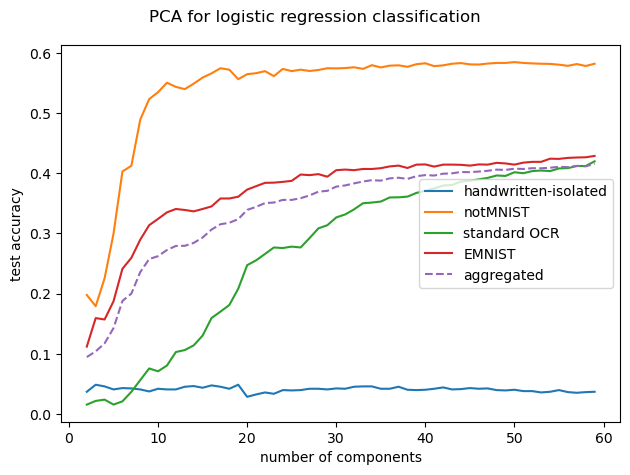

In [24]:
plot_scores(logreg_pca_results, range(2, 60), title="PCA for logistic regression classification")

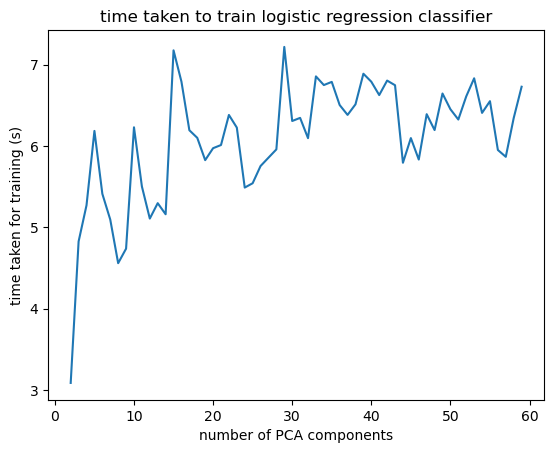

In [25]:
plt.plot(range(2, 60), logreg_pca_results["traintimes"], label="predict time")
plt.xlabel("number of PCA components")
plt.ylabel("time taken for training (s)")
plt.title("time taken to train logistic regression classifier")
plt.show()

### KNN classifier

In [26]:
knn_pca_results = test_trf_models(create_knn, pcatrf_funcs, 2, 59)

n_components: 2
KNN training took: 0.38216662406921387 sec.

Model testing took: 0.47905755043029785 sec.

handwritten-isolated score: 0.26729910714285715
notMNIST score: 0.19337606837606838
standard OCR score: 0.04848199576370911
EMNIST score: 0.15526315789473685
Aggregate score: 0.14666666666666667
------
n_components: 3
KNN training took: 0.42156147956848145 sec.

Model testing took: 0.4827084541320801 sec.

handwritten-isolated score: 0.32310267857142855
notMNIST score: 0.2999465811965812
standard OCR score: 0.09037420569545776
EMNIST score: 0.20032894736842105
Aggregate score: 0.2101364522417154
------
n_components: 4
KNN training took: 0.3916025161743164 sec.

Model testing took: 0.48090362548828125 sec.

handwritten-isolated score: 0.328125
notMNIST score: 0.3891559829059829
standard OCR score: 0.1831019063309014
EMNIST score: 0.24901315789473685
Aggregate score: 0.27914230019493175
------
n_components: 5
KNN training took: 0.3990671634674072 sec.

Model testing took: 0.67309117

In [27]:
np.max(knn_pca_results["aggscores"])

0.7981286549707602

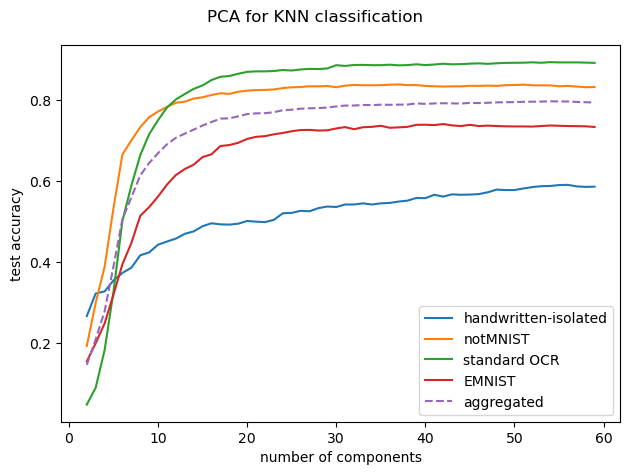

In [28]:
plot_scores(knn_pca_results, range(2, 60), title="PCA for KNN classification")

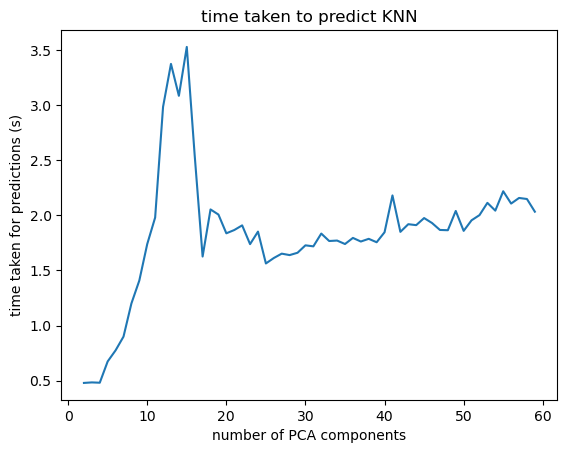

In [29]:
plt.plot(range(2, 60), knn_pca_results["predicttimes"], label="predict time")
plt.xlabel("number of PCA components")
plt.ylabel("time taken for predictions (s)")
plt.title("time taken to predict KNN")
plt.show()

### SVM

In [ ]:
# knn_pca_results = test_trf_models(create_knn, pcatrf_funcs, 2, 59)
# np.max(knn_pca_results["aggscores"])
# plot_scores(knn_pca_results, range(2, 60), title="PCA for KNN classification")
# plt.plot(range(2, 60), knn_pca_results["predicttimes"], label="predict time")
# plt.xlabel("number of PCA components")
# plt.ylabel("time taken for predictions (s)")
# plt.title("time taken to predict KNN")
# plt.show()

In [32]:
svm_pca_results = test_trf_models(create_svm, pcatrf_funcs[0:29], 2, 30)

n_components: 2
SVM training took: 247.24785375595093 sec.

Model testing took: 117.93903374671936 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.26789529914529914
standard OCR score: 0.03436102612379383
EMNIST score: 0.2042763157894737
Aggregate score: 0.14385964912280702
------
n_components: 3
SVM training took: 232.0246455669403 sec.

Model testing took: 109.81557846069336 sec.

handwritten-isolated score: 0.04743303571428571
notMNIST score: 0.34481837606837606
standard OCR score: 0.08025417745351847
EMNIST score: 0.25493421052631576
Aggregate score: 0.19430799220272904
------
n_components: 4
SVM training took: 203.7441008090973 sec.

Model testing took: 97.27609252929688 sec.

handwritten-isolated score: 0.056361607142857144
notMNIST score: 0.4094551282051282
standard OCR score: 0.151329724641092
EMNIST score: 0.2888157894736842
Aggregate score: 0.24600389863547759
------
n_components: 5
SVM training took: 150.63855528831482 sec.

Model testing took: 89.339

In [41]:
np.max(svm_pca_results["aggscores"])

0.7375438596491228

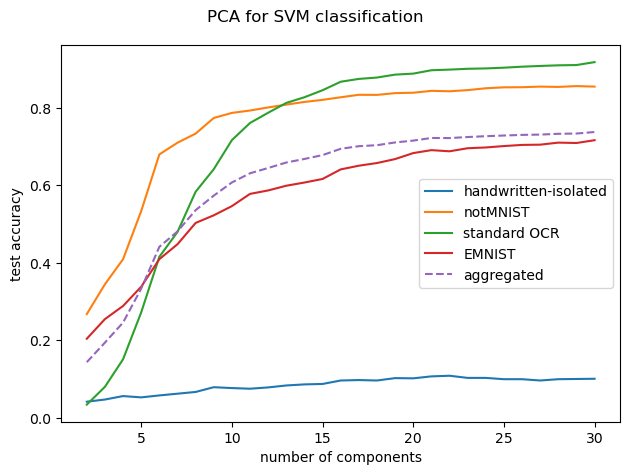

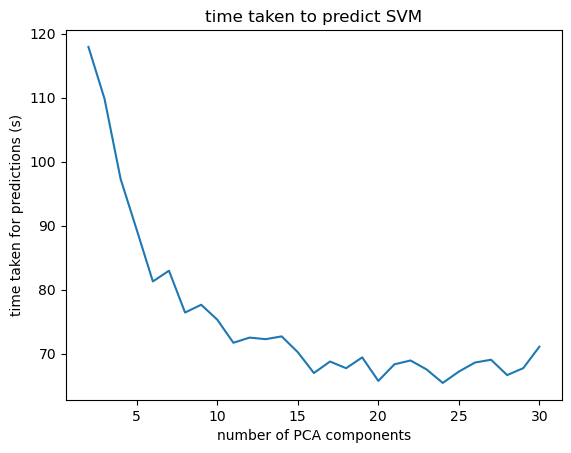

In [40]:
plot_scores(svm_pca_results, range(2, 31), title="PCA for SVM classification")
plt.plot(range(2, 31), svm_pca_results["predicttimes"], label="predict time")
plt.xlabel("number of PCA components")
plt.ylabel("time taken for predictions (s)")
plt.title("time taken to predict SVM")
plt.show()

### MLP

In [42]:
mlp_pca_results = test_trf_models(create_mlp, pcatrf_funcs[0:29], 2, 30)

n_components: 2
MLP training took: 56.604663133621216 sec.

Model testing took: 0.07533550262451172 sec.

handwritten-isolated score: 0.03794642857142857
notMNIST score: 0.26014957264957267
standard OCR score: 0.052247587667686515
EMNIST score: 0.1730263157894737
Aggregate score: 0.13957115009746587
------
n_components: 3


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 68.61643385887146 sec.

Model testing took: 0.08299016952514648 sec.

handwritten-isolated score: 0.04966517857142857
notMNIST score: 0.3031517094017094
standard OCR score: 0.08048952694751706
EMNIST score: 0.21973684210526315
Aggregate score: 0.17419103313840156
------
n_components: 4


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 77.61086535453796 sec.

Model testing took: 0.07199883460998535 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.3370726495726496
standard OCR score: 0.1572134619910567
EMNIST score: 0.2625
Aggregate score: 0.2190253411306043
------
n_components: 5


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 75.79795098304749 sec.

Model testing took: 0.0778036117553711 sec.

handwritten-isolated score: 0.04241071428571429
notMNIST score: 0.4337606837606838
standard OCR score: 0.25935514238644386
EMNIST score: 0.31842105263157894
Aggregate score: 0.2939571150097466
------
n_components: 6


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 79.05606436729431 sec.

Model testing took: 0.07800006866455078 sec.

handwritten-isolated score: 0.05859375
notMNIST score: 0.6303418803418803
standard OCR score: 0.3890327135796658
EMNIST score: 0.34638157894736843
Aggregate score: 0.40319688109161794
------
n_components: 7


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 77.35417628288269 sec.

Model testing took: 0.07522869110107422 sec.

handwritten-isolated score: 0.06138392857142857
notMNIST score: 0.6215277777777778
standard OCR score: 0.43469051541539183
EMNIST score: 0.40789473684210525
Aggregate score: 0.43072124756335284
------
n_components: 8
MLP training took: 71.32110738754272 sec.

Model testing took: 0.07702207565307617 sec.

handwritten-isolated score: 0.060267857142857144
notMNIST score: 0.625267094017094
standard OCR score: 0.5274182160508355
EMNIST score: 0.4493421052631579
Aggregate score: 0.4722027290448343
------
n_components: 9
MLP training took: 51.06057906150818 sec.

Model testing took: 0.07623004913330078 sec.

handwritten-isolated score: 0.04296875
notMNIST score: 0.6607905982905983
standard OCR score: 0.5782537067545305
EMNIST score: 0.47927631578947366
Aggregate score: 0.504093567251462
------
n_components: 10
MLP training took: 53.618447065353394 sec.

Model testing took: 0.07600259780883789 sec.

handwr

In [43]:
np.max(mlp_pca_results["aggscores"])

0.6709551656920077

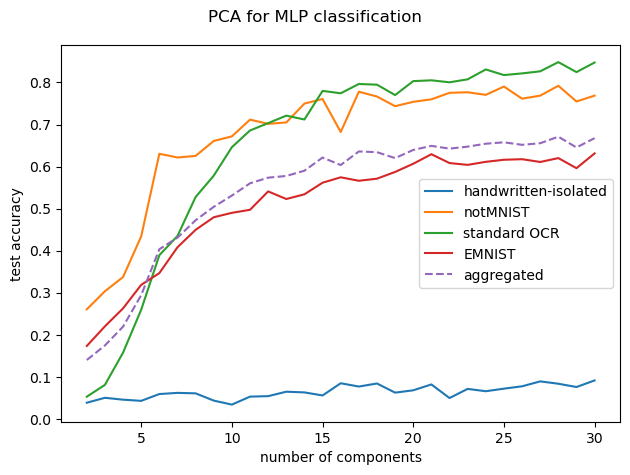

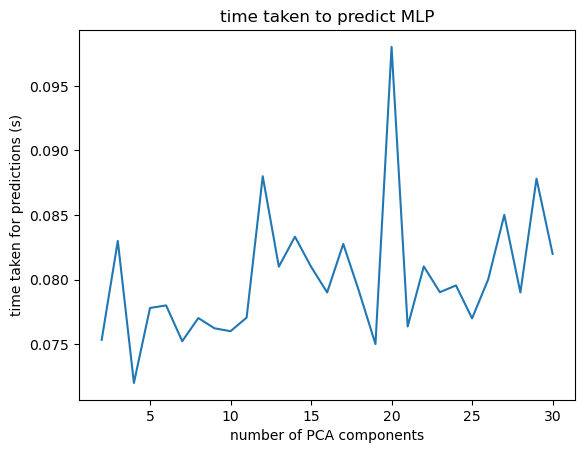

In [44]:
plot_scores(mlp_pca_results, range(2, 31), title="PCA for MLP classification")
plt.plot(range(2, 31), mlp_pca_results["predicttimes"], label="predict time")
plt.xlabel("number of PCA components")
plt.ylabel("time taken for predictions (s)")
plt.title("time taken to predict MLP")
plt.show()

## Tests with LDA

In [45]:
def create_lda(X, y, n_components):
    ts = utils.tic()
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    lda.fit(X, y)
    utils.toc(ts, "Creating LDA components")
    return lda
allldas = [create_lda(cons_train_data, cons_train_labels, i) for i in range(1, 35)]
ldatrf_funcs = [lda.transform for lda in allldas]

Creating LDA components took: 4.204546689987183 sec.

Creating LDA components took: 5.4894678592681885 sec.

Creating LDA components took: 5.752430200576782 sec.

Creating LDA components took: 5.242221117019653 sec.

Creating LDA components took: 5.359363555908203 sec.

Creating LDA components took: 5.2161102294921875 sec.

Creating LDA components took: 5.271024703979492 sec.

Creating LDA components took: 5.165754318237305 sec.

Creating LDA components took: 5.245802402496338 sec.

Creating LDA components took: 5.219418048858643 sec.

Creating LDA components took: 5.244571685791016 sec.

Creating LDA components took: 5.190398454666138 sec.

Creating LDA components took: 5.197535276412964 sec.

Creating LDA components took: 5.467479467391968 sec.

Creating LDA components took: 5.302328109741211 sec.

Creating LDA components took: 5.1833717823028564 sec.

Creating LDA components took: 5.212993621826172 sec.

Creating LDA components took: 5.230686902999878 sec.

Creating LDA components t

In [46]:
ldatrf_funcs = [lda.transform for lda in allldas]

### Logistic regression linear classifier

In [47]:
logreg_lda_results = test_trf_models(create_logreg, ldatrf_funcs, 1, 34)

n_components: 1
Logistic Regression training took: 1.309859275817871 sec.

Model testing took: 0.03600287437438965 sec.

handwritten-isolated score: 0.04296875
notMNIST score: 0.1372863247863248
standard OCR score: 0.051070840197693576
EMNIST score: 0.0875
Aggregate score: 0.08374269005847954
------
n_components: 2
Logistic Regression training took: 1.4133319854736328 sec.

Model testing took: 0.041287899017333984 sec.

handwritten-isolated score: 0.030691964285714284
notMNIST score: 0.23050213675213677
standard OCR score: 0.04706989879971758
EMNIST score: 0.20986842105263157
Aggregate score: 0.13692007797270955
------
n_components: 3
Logistic Regression training took: 1.5479893684387207 sec.

Model testing took: 0.041559457778930664 sec.

handwritten-isolated score: 0.03180803571428571
notMNIST score: 0.2831196581196581
standard OCR score: 0.07554718757354671
EMNIST score: 0.22763157894736843
Aggregate score: 0.16608187134502925
------
n_components: 4
Logistic Regression training took

In [48]:
np.max(logreg_lda_results["aggscores"])

0.41551656920077973

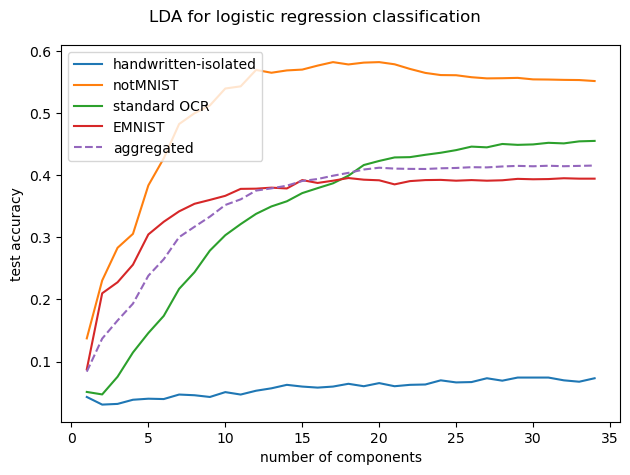

In [49]:
plot_scores(logreg_lda_results, range(1, 35), title="LDA for logistic regression classification")

### KNN classifier

In [ ]:
knn_lda_results = test_trf_models(create_knn, ldatrf_funcs, 1, 34)

n_components: 1
KNN training took: 0.23538589477539062 sec.

Model testing took: 0.23496794700622559 sec.

handwritten-isolated score: 0.20145089285714285
notMNIST score: 0.10016025641025642
standard OCR score: 0.04542245234172747
EMNIST score: 0.09539473684210527
Aggregate score: 0.09504873294346979
------
n_components: 2
KNN training took: 0.16946792602539062 sec.

Model testing took: 0.20495080947875977 sec.

handwritten-isolated score: 0.23158482142857142
notMNIST score: 0.18162393162393162
standard OCR score: 0.06942810072958343
EMNIST score: 0.16907894736842105
Aggregate score: 0.14846003898635476
------
n_components: 3
KNN training took: 0.16876983642578125 sec.

Model testing took: 0.3192260265350342 sec.

handwritten-isolated score: 0.32421875
notMNIST score: 0.28338675213675213
standard OCR score: 0.10284772887738292
EMNIST score: 0.20164473684210527
Aggregate score: 0.20990253411306042
------
n_components: 4
KNN training took: 0.16770267486572266 sec.

Model testing took: 0.

In [ ]:
np.max(knn_lda_results["aggscores"])

0.6708771929824562

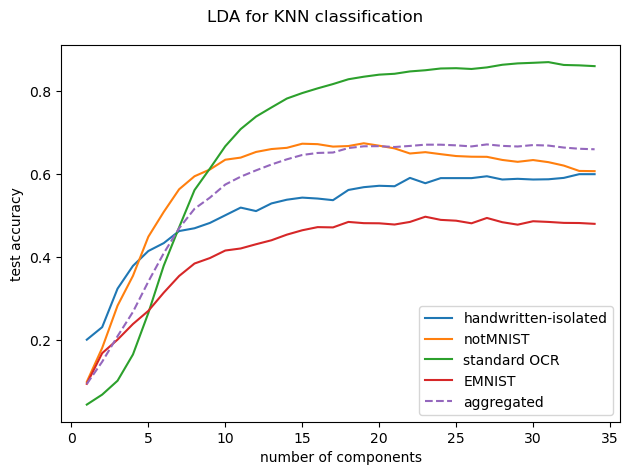

In [ ]:
plot_scores(knn_lda_results, range(1, 35), title="LDA for KNN classification")

### SVM

In [51]:
svm_lda_results=test_trf_models(create_svm, ldatrf_funcs[0:20], 1, 20)

n_components: 1
SVM training took: 221.050772190094 sec.

Model testing took: 79.21692395210266 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.11565170940170941
standard OCR score: 0.06048481995763709
EMNIST score: 0.1424342105263158
Aggregate score: 0.09387914230019494
------
n_components: 2
SVM training took: 165.54709243774414 sec.

Model testing took: 79.0884780883789 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.2903311965811966
standard OCR score: 0.08213697340550717
EMNIST score: 0.2361842105263158
Aggregate score: 0.17380116959064326
------
n_components: 3
SVM training took: 151.21420240402222 sec.

Model testing took: 77.05179619789124 sec.

handwritten-isolated score: 0.041294642857142856
notMNIST score: 0.35844017094017094
standard OCR score: 0.12402918333725582
EMNIST score: 0.26217105263157897
Aggregate score: 0.21364522417153997
------
n_components: 4
SVM training took: 128.02346086502075 sec.

Model testing took: 76.311

In [52]:
np.max(svm_lda_results["aggscores"])

0.6200389863547758

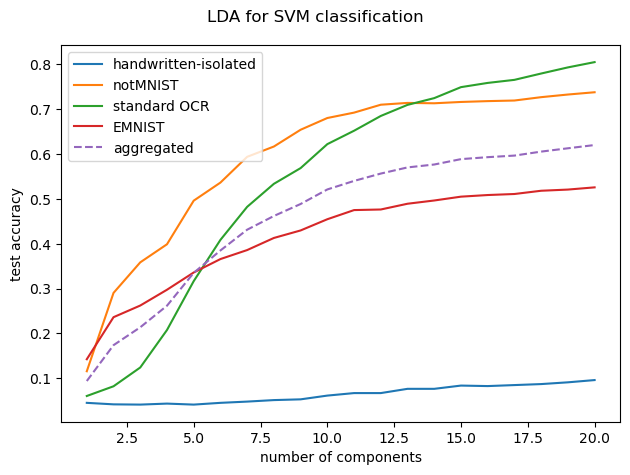

In [53]:
plot_scores(svm_lda_results,range(1,21),title='LDA for SVM classification')

### MLP

In [54]:
mlp_lda_results=test_trf_models(create_mlp,ldatrf_funcs[0:20],1,20)

n_components: 1
MLP training took: 82.07921648025513 sec.

Model testing took: 0.07052373886108398 sec.

handwritten-isolated score: 0.04017857142857143
notMNIST score: 0.11965811965811966
standard OCR score: 0.05083549070369499
EMNIST score: 0.14769736842105263
Aggregate score: 0.09239766081871345
------
n_components: 2
MLP training took: 58.50857138633728 sec.

Model testing took: 0.06400060653686523 sec.

handwritten-isolated score: 0.04352678571428571
notMNIST score: 0.2783119658119658
standard OCR score: 0.09413979759943517
EMNIST score: 0.23026315789473684
Aggregate score: 0.17309941520467836
------
n_components: 3


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 67.66707134246826 sec.

Model testing took: 0.05398225784301758 sec.

handwritten-isolated score: 0.052455357142857144
notMNIST score: 0.3327991452991453
standard OCR score: 0.16851023770298895
EMNIST score: 0.2523026315789474
Aggregate score: 0.2201169590643275
------
n_components: 4


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 79.61916375160217 sec.

Model testing took: 0.054015398025512695 sec.

handwritten-isolated score: 0.05803571428571429
notMNIST score: 0.39449786324786323
standard OCR score: 0.23040715462461756
EMNIST score: 0.29046052631578945
Aggregate score: 0.2684600389863548
------
n_components: 5


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 80.54707384109497 sec.

Model testing took: 0.05900216102600098 sec.

handwritten-isolated score: 0.06584821428571429
notMNIST score: 0.47889957264957267
standard OCR score: 0.3330195340080019
EMNIST score: 0.32171052631578945
Aggregate score: 0.3355945419103314
------
n_components: 6


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 81.10900211334229 sec.

Model testing took: 0.0596773624420166 sec.

handwritten-isolated score: 0.06417410714285714
notMNIST score: 0.5248397435897436
standard OCR score: 0.4233937397034596
EMNIST score: 0.3549342105263158
Aggregate score: 0.38658869395711504
------
n_components: 7


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 82.14528512954712 sec.

Model testing took: 0.0579831600189209 sec.

handwritten-isolated score: 0.07198660714285714
notMNIST score: 0.5734508547008547
standard OCR score: 0.4876441515650741
EMNIST score: 0.3786184210526316
Aggregate score: 0.4287719298245614
------
n_components: 8


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 81.63638305664062 sec.

Model testing took: 0.0563504695892334 sec.

handwritten-isolated score: 0.0703125
notMNIST score: 0.5956196581196581
standard OCR score: 0.5236526241468581
EMNIST score: 0.3980263157894737
Aggregate score: 0.45153996101364524
------
n_components: 9


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 81.68078231811523 sec.

Model testing took: 0.05850815773010254 sec.

handwritten-isolated score: 0.07589285714285714
notMNIST score: 0.6351495726495726
standard OCR score: 0.5563662038126618
EMNIST score: 0.4151315789473684
Aggregate score: 0.4787524366471735
------
n_components: 10


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 82.8486738204956 sec.

Model testing took: 0.05701875686645508 sec.

handwritten-isolated score: 0.08649553571428571
notMNIST score: 0.655448717948718
standard OCR score: 0.5944928218404331
EMNIST score: 0.4361842105263158
Aggregate score: 0.5037816764132553
------
n_components: 11


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 78.15774846076965 sec.

Model testing took: 0.057177066802978516 sec.

handwritten-isolated score: 0.08705357142857142
notMNIST score: 0.6613247863247863
standard OCR score: 0.6269710520122381
EMNIST score: 0.4513157894736842
Aggregate score: 0.5199220272904483
------
n_components: 12


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 77.7073335647583 sec.

Model testing took: 0.05499863624572754 sec.

handwritten-isolated score: 0.08705357142857142
notMNIST score: 0.6813568376068376
standard OCR score: 0.6469757590021181
EMNIST score: 0.45230263157894735
Aggregate score: 0.5326315789473685
------
n_components: 13


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 82.74177765846252 sec.

Model testing took: 0.059021949768066406 sec.

handwritten-isolated score: 0.09430803571428571
notMNIST score: 0.6784188034188035
standard OCR score: 0.6787479406919276
EMNIST score: 0.4529605263157895
Aggregate score: 0.5434697855750488
------
n_components: 14


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 84.48128604888916 sec.

Model testing took: 0.06101846694946289 sec.

handwritten-isolated score: 0.0625
notMNIST score: 0.6813568376068376
standard OCR score: 0.682513532595905
EMNIST score: 0.4618421052631579
Aggregate score: 0.5432358674463937
------
n_components: 15


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 84.66977834701538 sec.

Model testing took: 0.055999755859375 sec.

handwritten-isolated score: 0.08314732142857142
notMNIST score: 0.6899038461538461
standard OCR score: 0.7131089668157213
EMNIST score: 0.4805921052631579
Aggregate score: 0.5631968810916179
------
n_components: 16


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 82.86596703529358 sec.

Model testing took: 0.06300115585327148 sec.

handwritten-isolated score: 0.09598214285714286
notMNIST score: 0.6832264957264957
standard OCR score: 0.7187573546716874
EMNIST score: 0.47598684210526315
Aggregate score: 0.5638206627680312
------
n_components: 17


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 83.53803014755249 sec.

Model testing took: 0.057999372482299805 sec.

handwritten-isolated score: 0.10100446428571429
notMNIST score: 0.6941773504273504
standard OCR score: 0.7199341021416804
EMNIST score: 0.4651315789473684
Aggregate score: 0.5655360623781677
------
n_components: 18


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 84.91314888000488 sec.

Model testing took: 0.058000802993774414 sec.

handwritten-isolated score: 0.08091517857142858
notMNIST score: 0.6968482905982906
standard OCR score: 0.7415862555895505
EMNIST score: 0.47039473684210525
Aggregate score: 0.5719298245614035
------
n_components: 19


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP training took: 82.61917519569397 sec.

Model testing took: 0.061192989349365234 sec.

handwritten-isolated score: 0.09151785714285714
notMNIST score: 0.7003205128205128
standard OCR score: 0.7575900211814545
EMNIST score: 0.4805921052631579
Aggregate score: 0.5821442495126705
------
n_components: 20
MLP training took: 83.14486765861511 sec.

Model testing took: 0.06499958038330078 sec.

handwritten-isolated score: 0.08203125
notMNIST score: 0.7056623931623932
standard OCR score: 0.7597081666274418
EMNIST score: 0.47927631578947366
Aggregate score: 0.5827680311890838
------


c:\Users\cheng\anaconda3\envs\ECE253\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [55]:
np.max(mlp_lda_results['aggscores'])

0.5827680311890838

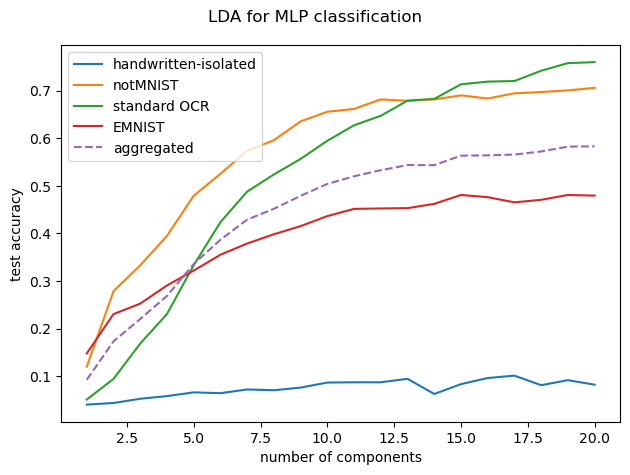

In [56]:
plot_scores(mlp_lda_results,range(1,21),title='LDA for MLP classification')

## Tests with random Gaussian projection

In [57]:
allgrps = [GaussianRandomProjection(n_components=i, random_state=1).fit(cons_train_data) for i in range(2, 60)]
rgptrf_funcs = [grp.transform for grp in allgrps]

### Logistic regression

In [ ]:
logreg_rgp_results = test_trf_models(create_logreg, rgptrf_funcs, 2, 59)

n_components: 2


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.3396120071411133 sec.

Model testing took: 0.0171048641204834 sec.

handwritten-isolated score: 0.027901785714285716
notMNIST score: 0.13808760683760685
standard OCR score: 0.01670981407389974
EMNIST score: 0.05756578947368421
Aggregate score: 0.06339181286549708
------
n_components: 3


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.2592198848724365 sec.

Model testing took: 0.03170895576477051 sec.

handwritten-isolated score: 0.03404017857142857
notMNIST score: 0.13995726495726496
standard OCR score: 0.014827018121911038
EMNIST score: 0.08980263157894737
Aggregate score: 0.07181286549707602
------
n_components: 4


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.424046039581299 sec.

Model testing took: 0.019509077072143555 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.2045940170940171
standard OCR score: 0.01459166862791245
EMNIST score: 0.12861842105263158
Aggregate score: 0.1002729044834308
------
n_components: 5


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.5510919094085693 sec.

Model testing took: 0.02687382698059082 sec.

handwritten-isolated score: 0.048549107142857144
notMNIST score: 0.24145299145299146
standard OCR score: 0.016474464579901153
EMNIST score: 0.1305921052631579
Aggregate score: 0.11368421052631579
------
n_components: 6


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.357846975326538 sec.

Model testing took: 0.040891170501708984 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.22756410256410256
standard OCR score: 0.024005648387855967
EMNIST score: 0.13486842105263158
Aggregate score: 0.1122027290448343
------
n_components: 7


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.3108131885528564 sec.

Model testing took: 0.021893024444580078 sec.

handwritten-isolated score: 0.04296875
notMNIST score: 0.23317307692307693
standard OCR score: 0.031066133207813602
EMNIST score: 0.14769736842105263
Aggregate score: 0.11937621832358675
------
n_components: 8


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.4999210834503174 sec.

Model testing took: 0.025614023208618164 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.2419871794871795
standard OCR score: 0.032948929159802305
EMNIST score: 0.15756578947368421
Aggregate score: 0.12475633528265107
------
n_components: 9


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.152340888977051 sec.

Model testing took: 0.030565977096557617 sec.

handwritten-isolated score: 0.04352678571428571
notMNIST score: 0.27323717948717946
standard OCR score: 0.03436102612379383
EMNIST score: 0.16578947368421051
Aggregate score: 0.13653021442495128
------
n_components: 10


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.4507670402526855 sec.

Model testing took: 0.022507190704345703 sec.

handwritten-isolated score: 0.048549107142857144
notMNIST score: 0.30822649572649574
standard OCR score: 0.03341962814779948
EMNIST score: 0.1763157894736842
Aggregate score: 0.14962962962962964
------
n_components: 11


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.5706968307495117 sec.

Model testing took: 0.04988694190979004 sec.

handwritten-isolated score: 0.056919642857142856
notMNIST score: 0.3173076923076923
standard OCR score: 0.0369498705577783
EMNIST score: 0.1944078947368421
Aggregate score: 0.1589083820662768
------
n_components: 12


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.701948881149292 sec.

Model testing took: 0.026475191116333008 sec.

handwritten-isolated score: 0.06305803571428571
notMNIST score: 0.3301282051282051
standard OCR score: 0.042598258413744414
EMNIST score: 0.19736842105263158
Aggregate score: 0.16608187134502925
------
n_components: 13


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.640212059020996 sec.

Model testing took: 0.03666996955871582 sec.

handwritten-isolated score: 0.05915178571428571
notMNIST score: 0.3418803418803419
standard OCR score: 0.042362908919745826
EMNIST score: 0.20526315789473684
Aggregate score: 0.17076023391812867
------
n_components: 14


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.576205015182495 sec.

Model testing took: 0.04974699020385742 sec.

handwritten-isolated score: 0.05803571428571429
notMNIST score: 0.35336538461538464
standard OCR score: 0.05365968463167804
EMNIST score: 0.2026315789473684
Aggregate score: 0.17707602339181286
------
n_components: 15


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.7141339778900146 sec.

Model testing took: 0.051207780838012695 sec.

handwritten-isolated score: 0.05357142857142857
notMNIST score: 0.35870726495726496
standard OCR score: 0.05930807248764415
EMNIST score: 0.20296052631578948
Aggregate score: 0.17996101364522418
------
n_components: 16


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.878371238708496 sec.

Model testing took: 0.027419090270996094 sec.

handwritten-isolated score: 0.052455357142857144
notMNIST score: 0.3720619658119658
standard OCR score: 0.06260296540362438
EMNIST score: 0.2075657894736842
Aggregate score: 0.1858869395711501
------
n_components: 17


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.660276174545288 sec.

Model testing took: 0.037000179290771484 sec.

handwritten-isolated score: 0.05078125
notMNIST score: 0.37286324786324787
standard OCR score: 0.07413509060955518
EMNIST score: 0.22072368421052632
Aggregate score: 0.19282651072124757
------
n_components: 18


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.539095163345337 sec.

Model testing took: 0.037503957748413086 sec.

handwritten-isolated score: 0.046875
notMNIST score: 0.39663461538461536
standard OCR score: 0.07837138150152977
EMNIST score: 0.22894736842105262
Aggregate score: 0.20257309941520468
------
n_components: 19


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 3.600369930267334 sec.

Model testing took: 0.03593015670776367 sec.

handwritten-isolated score: 0.048549107142857144
notMNIST score: 0.41773504273504275
standard OCR score: 0.0837844198634973
EMNIST score: 0.22828947368421051
Aggregate score: 0.21060428849902535
------
n_components: 20


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.463447093963623 sec.

Model testing took: 0.04059600830078125 sec.

handwritten-isolated score: 0.04799107142857143
notMNIST score: 0.43349358974358976
standard OCR score: 0.09861143798540833
EMNIST score: 0.24605263157894736
Aggregate score: 0.2242495126705653
------
n_components: 21


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.6131391525268555 sec.

Model testing took: 0.031161069869995117 sec.

handwritten-isolated score: 0.048549107142857144
notMNIST score: 0.44604700854700857
standard OCR score: 0.09861143798540833
EMNIST score: 0.24407894736842106
Aggregate score: 0.22752436647173488
------
n_components: 22


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.611991882324219 sec.

Model testing took: 0.025671958923339844 sec.

handwritten-isolated score: 0.05133928571428571
notMNIST score: 0.45058760683760685
standard OCR score: 0.11108496116733349
EMNIST score: 0.2542763157894737
Aggregate score: 0.23578947368421052
------
n_components: 23


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.60490083694458 sec.

Model testing took: 0.027897119522094727 sec.

handwritten-isolated score: 0.05357142857142857
notMNIST score: 0.4543269230769231
standard OCR score: 0.12026359143327842
EMNIST score: 0.25493421052631576
Aggregate score: 0.2403898635477583
------
n_components: 24


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.611923933029175 sec.

Model testing took: 0.0367588996887207 sec.

handwritten-isolated score: 0.049107142857142856
notMNIST score: 0.4567307692307692
standard OCR score: 0.1263826782772417
EMNIST score: 0.25921052631578945
Aggregate score: 0.24350877192982456
------
n_components: 25


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.719002962112427 sec.

Model testing took: 0.03112506866455078 sec.

handwritten-isolated score: 0.05022321428571429
notMNIST score: 0.45699786324786323
standard OCR score: 0.13108966815721346
EMNIST score: 0.25921052631578945
Aggregate score: 0.24530214424951266
------
n_components: 26


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.966938018798828 sec.

Model testing took: 0.04055595397949219 sec.

handwritten-isolated score: 0.05078125
notMNIST score: 0.45860042735042733
standard OCR score: 0.13461991056719227
EMNIST score: 0.2680921052631579
Aggregate score: 0.24912280701754386
------
n_components: 27


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.660482883453369 sec.

Model testing took: 0.039999961853027344 sec.

handwritten-isolated score: 0.05078125
notMNIST score: 0.4706196581196581
standard OCR score: 0.1416803953871499
EMNIST score: 0.27171052631578946
Aggregate score: 0.25582846003898635
------
n_components: 28


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.154078960418701 sec.

Model testing took: 0.04811739921569824 sec.

handwritten-isolated score: 0.053013392857142856
notMNIST score: 0.4740918803418803
standard OCR score: 0.1435631913391386
EMNIST score: 0.2743421052631579
Aggregate score: 0.258401559454191
------
n_components: 29


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.731131076812744 sec.

Model testing took: 0.05166196823120117 sec.

handwritten-isolated score: 0.056361607142857144
notMNIST score: 0.47489316239316237
standard OCR score: 0.14615203577312308
EMNIST score: 0.2730263157894737
Aggregate score: 0.2596491228070175
------
n_components: 30


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.691986083984375 sec.

Model testing took: 0.03341412544250488 sec.

handwritten-isolated score: 0.05189732142857143
notMNIST score: 0.46821581196581197
standard OCR score: 0.1534478700870793
EMNIST score: 0.2792763157894737
Aggregate score: 0.2609746588693957
------
n_components: 31


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.474925994873047 sec.

Model testing took: 0.0659799575805664 sec.

handwritten-isolated score: 0.053013392857142856
notMNIST score: 0.469017094017094
standard OCR score: 0.16192045187102846
EMNIST score: 0.2845394736842105
Aggregate score: 0.26541910331384017
------
n_components: 32


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.002288818359375 sec.

Model testing took: 0.05230116844177246 sec.

handwritten-isolated score: 0.04966517857142857
notMNIST score: 0.46928418803418803
standard OCR score: 0.16074370440103553
EMNIST score: 0.2858552631578947
Aggregate score: 0.2649512670565302
------
n_components: 33


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.7097249031066895 sec.

Model testing took: 0.057412147521972656 sec.

handwritten-isolated score: 0.05524553571428571
notMNIST score: 0.4700854700854701
standard OCR score: 0.17274652859496353
EMNIST score: 0.2930921052631579
Aggregate score: 0.2716569200779727
------
n_components: 34


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.419523000717163 sec.

Model testing took: 0.04177093505859375 sec.

handwritten-isolated score: 0.052455357142857144
notMNIST score: 0.46981837606837606
standard OCR score: 0.17580607201694518
EMNIST score: 0.29736842105263156
Aggregate score: 0.27321637426900586
------
n_components: 35


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.275170087814331 sec.

Model testing took: 0.04529309272766113 sec.

handwritten-isolated score: 0.05412946428571429
notMNIST score: 0.47435897435897434
standard OCR score: 0.17957166392092258
EMNIST score: 0.3046052631578947
Aggregate score: 0.27773879142300195
------
n_components: 36


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.631582975387573 sec.

Model testing took: 0.04578208923339844 sec.

handwritten-isolated score: 0.053013392857142856
notMNIST score: 0.4740918803418803
standard OCR score: 0.1849847022828901
EMNIST score: 0.30855263157894736
Aggregate score: 0.28023391812865495
------
n_components: 37


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.6493449211120605 sec.

Model testing took: 0.04077410697937012 sec.

handwritten-isolated score: 0.05412946428571429
notMNIST score: 0.47596153846153844
standard OCR score: 0.18616144975288304
EMNIST score: 0.3078947368421053
Aggregate score: 0.28116959064327485
------
n_components: 38


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.927716016769409 sec.

Model testing took: 0.050563812255859375 sec.

handwritten-isolated score: 0.05412946428571429
notMNIST score: 0.4754273504273504
standard OCR score: 0.19016239115085903
EMNIST score: 0.30986842105263157
Aggregate score: 0.2828070175438597
------
n_components: 39


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.061823129653931 sec.

Model testing took: 0.04702591896057129 sec.

handwritten-isolated score: 0.05524553571428571
notMNIST score: 0.47302350427350426
standard OCR score: 0.19534008001882797
EMNIST score: 0.30986842105263157
Aggregate score: 0.2839766081871345
------
n_components: 40


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.939636945724487 sec.

Model testing took: 0.04644608497619629 sec.

handwritten-isolated score: 0.05078125
notMNIST score: 0.4735576923076923
standard OCR score: 0.19910567192280537
EMNIST score: 0.3167763157894737
Aggregate score: 0.28639376218323587
------
n_components: 41


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.680129051208496 sec.

Model testing took: 0.07049989700317383 sec.

handwritten-isolated score: 0.046875
notMNIST score: 0.47489316239316237
standard OCR score: 0.20875500117674747
EMNIST score: 0.31546052631578947
Aggregate score: 0.28912280701754384
------
n_components: 42


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.4852001667022705 sec.

Model testing took: 0.11042594909667969 sec.

handwritten-isolated score: 0.04966517857142857
notMNIST score: 0.4722222222222222
standard OCR score: 0.20946104965874324
EMNIST score: 0.3194078947368421
Aggregate score: 0.28990253411306044
------
n_components: 43


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.3308069705963135 sec.

Model testing took: 0.04949498176574707 sec.

handwritten-isolated score: 0.05524553571428571
notMNIST score: 0.4807692307692308
standard OCR score: 0.21110849611673335
EMNIST score: 0.31743421052631576
Aggregate score: 0.29325536062378166
------
n_components: 44


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.330359935760498 sec.

Model testing took: 0.03723883628845215 sec.

handwritten-isolated score: 0.05357142857142857
notMNIST score: 0.47836538461538464
standard OCR score: 0.21628618498470228
EMNIST score: 0.3203947368421053
Aggregate score: 0.29473684210526313
------
n_components: 45


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.978806018829346 sec.

Model testing took: 0.05252408981323242 sec.

handwritten-isolated score: 0.052455357142857144
notMNIST score: 0.4740918803418803
standard OCR score: 0.22122852435867263
EMNIST score: 0.3213815789473684
Aggregate score: 0.2952046783625731
------
n_components: 46


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.9511659145355225 sec.

Model testing took: 0.04298806190490723 sec.

handwritten-isolated score: 0.05357142857142857
notMNIST score: 0.4909188034188034
standard OCR score: 0.21911037891268534
EMNIST score: 0.32105263157894737
Aggregate score: 0.29949317738791426
------
n_components: 47


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.775940179824829 sec.

Model testing took: 0.06799912452697754 sec.

handwritten-isolated score: 0.05524553571428571
notMNIST score: 0.4855769230769231
standard OCR score: 0.22405271828665568
EMNIST score: 0.3269736842105263
Aggregate score: 0.3012085769980507
------
n_components: 48


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.472879886627197 sec.

Model testing took: 0.05425381660461426 sec.

handwritten-isolated score: 0.0546875
notMNIST score: 0.48691239316239315
standard OCR score: 0.22499411626265003
EMNIST score: 0.3269736842105263
Aggregate score: 0.30183235867446395
------
n_components: 49


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.923567056655884 sec.

Model testing took: 0.09111499786376953 sec.

handwritten-isolated score: 0.05580357142857143
notMNIST score: 0.48824786324786323
standard OCR score: 0.2332313485526006
EMNIST score: 0.32861842105263156
Aggregate score: 0.3054970760233918
------
n_components: 50


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.017869234085083 sec.

Model testing took: 0.09419798851013184 sec.

handwritten-isolated score: 0.05357142857142857
notMNIST score: 0.48664529914529914
standard OCR score: 0.23817368792657095
EMNIST score: 0.33092105263157895
Aggregate score: 0.3069005847953216
------
n_components: 51


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.937790870666504 sec.

Model testing took: 0.09687113761901855 sec.

handwritten-isolated score: 0.049107142857142856
notMNIST score: 0.49011752136752135
standard OCR score: 0.24546952224052718
EMNIST score: 0.33421052631578946
Aggregate score: 0.31048732943469787
------
n_components: 52


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.7055699825286865 sec.

Model testing took: 0.05077004432678223 sec.

handwritten-isolated score: 0.05022321428571429
notMNIST score: 0.49145299145299143
standard OCR score: 0.2504118616144975
EMNIST score: 0.3361842105263158
Aggregate score: 0.3131384015594542
------
n_components: 53


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.67460298538208 sec.

Model testing took: 0.06519079208374023 sec.

handwritten-isolated score: 0.05133928571428571
notMNIST score: 0.4890491452991453
standard OCR score: 0.253000706048482
EMNIST score: 0.3371710526315789
Aggregate score: 0.3136842105263158
------
n_components: 54


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.520593881607056 sec.

Model testing took: 0.042088985443115234 sec.

handwritten-isolated score: 0.048549107142857144
notMNIST score: 0.49572649572649574
standard OCR score: 0.25582489997646507
EMNIST score: 0.3401315789473684
Aggregate score: 0.3168810916179337
------
n_components: 55


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.041200876235962 sec.

Model testing took: 0.05400490760803223 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.4949252136752137
standard OCR score: 0.2588844433984467
EMNIST score: 0.33980263157894736
Aggregate score: 0.3171150097465887
------
n_components: 56


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.601222991943359 sec.

Model testing took: 0.03617715835571289 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.5024038461538461
standard OCR score: 0.2591197928924453
EMNIST score: 0.3430921052631579
Aggregate score: 0.3201559454191033
------
n_components: 57


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 4.636379241943359 sec.

Model testing took: 0.04970383644104004 sec.

handwritten-isolated score: 0.040736607142857144
notMNIST score: 0.49732905982905984
standard OCR score: 0.25817839491645095
EMNIST score: 0.34375
Aggregate score: 0.3178947368421053
------
n_components: 58


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.499812841415405 sec.

Model testing took: 0.06538009643554688 sec.

handwritten-isolated score: 0.04575892857142857
notMNIST score: 0.49759615384615385
standard OCR score: 0.26123793833843256
EMNIST score: 0.3450657894736842
Aggregate score: 0.32
------
n_components: 59
Logistic Regression training took: 5.29203987121582 sec.

Model testing took: 0.0463559627532959 sec.

handwritten-isolated score: 0.044642857142857144
notMNIST score: 0.49919871794871795
standard OCR score: 0.26006119086843965
EMNIST score: 0.3404605263157895
Aggregate score: 0.31883040935672513
------


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
np.max(logreg_rgp_results["aggscores"])

0.3201559454191033

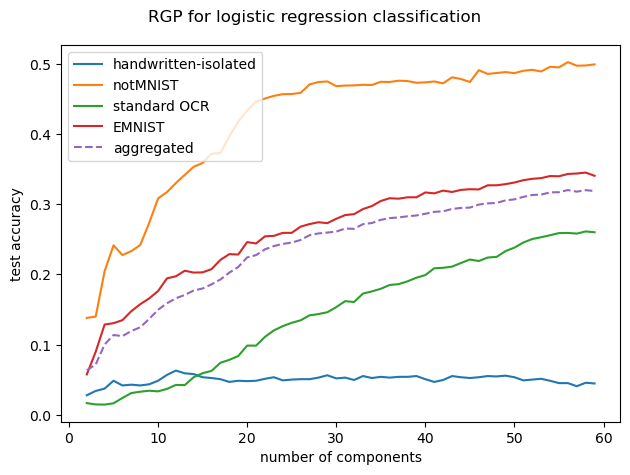

In [ ]:
plot_scores(logreg_rgp_results, range(2, 60), title="RGP for logistic regression classification")

### KNN

In [ ]:
knn_rgp_results = test_trf_models(create_knn, rgptrf_funcs, 2, 59)

n_components: 2


KNN training took: 0.1815030574798584 sec.

Model testing took: 0.19801783561706543 sec.

handwritten-isolated score: 0.23604910714285715
notMNIST score: 0.06677350427350427
standard OCR score: 0.03318427865380089
EMNIST score: 0.07664473684210527
Aggregate score: 0.0816374269005848
------
n_components: 3
KNN training took: 0.1156010627746582 sec.

Model testing took: 0.21065187454223633 sec.

handwritten-isolated score: 0.27901785714285715
notMNIST score: 0.11004273504273504
standard OCR score: 0.06072016945163568
EMNIST score: 0.10625
Aggregate score: 0.11641325536062379
------
n_components: 4
KNN training took: 0.10764098167419434 sec.

Model testing took: 0.23465180397033691 sec.

handwritten-isolated score: 0.35323660714285715
notMNIST score: 0.18803418803418803
standard OCR score: 0.10261237938338433
EMNIST score: 0.1375
Aggregate score: 0.17083820662768032
------
n_components: 5
KNN training took: 0.1099851131439209 sec.

Model testing took: 0.3023550510406494 sec.

handwritten-

In [ ]:
np.max(knn_rgp_results["aggscores"])

0.7421442495126706

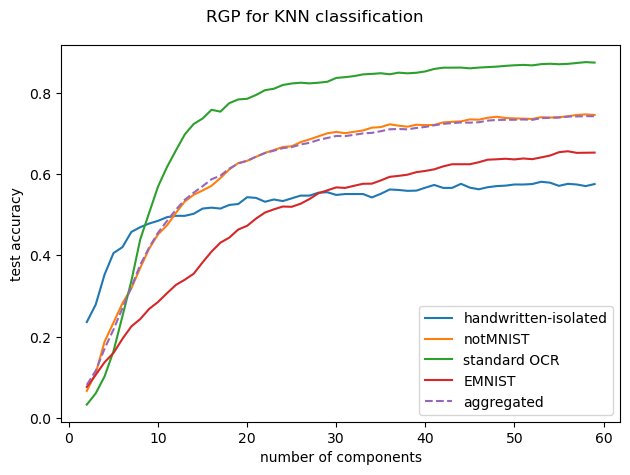

In [ ]:
plot_scores(knn_rgp_results, range(2, 60), title="RGP for KNN classification")

### SVM

In [59]:
svm_rgp_results=test_trf_models(create_svm,rgptrf_funcs[0:29], 2, 30)

n_components: 2
SVM training took: 239.61702346801758 sec.

Model testing took: 81.0214593410492 sec.

handwritten-isolated score: 0.03850446428571429
notMNIST score: 0.1469017094017094
standard OCR score: 0.025417745351847494
EMNIST score: 0.11447368421052631
Aggregate score: 0.08382066276803118
------
n_components: 3
SVM training took: 211.00804829597473 sec.

Model testing took: 82.25186276435852 sec.

handwritten-isolated score: 0.03627232142857143
notMNIST score: 0.16987179487179488
standard OCR score: 0.04659919981172041
EMNIST score: 0.15263157894736842
Aggregate score: 0.10627680311890839
------
n_components: 4
SVM training took: 193.0627143383026 sec.

Model testing took: 89.66498255729675 sec.

handwritten-isolated score: 0.045200892857142856
notMNIST score: 0.2545405982905983
standard OCR score: 0.07907742998352553
EMNIST score: 0.18914473684210525
Aggregate score: 0.1516569200779727
------
n_components: 5
SVM training took: 247.1724922657013 sec.

Model testing took: 94.689

In [60]:
np.max(svm_rgp_results['aggscores'])

0.5489278752436647

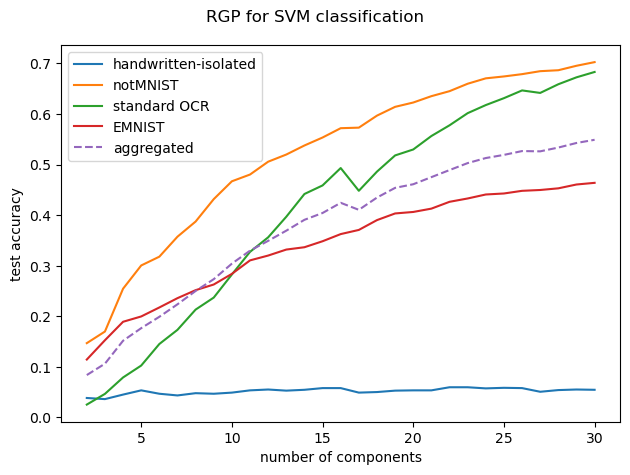

In [62]:
plot_scores(svm_rgp_results, range(2, 31), title="RGP for SVM classification")

### MLP

In [63]:
mlp_rgp_results=test_trf_models(create_mlp,rgptrf_funcs[0:29], 2, 30)

n_components: 2
MLP training took: 91.16667032241821 sec.

Model testing took: 0.06072545051574707 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.1543803418803419
standard OCR score: 0.030830783713815015
EMNIST score: 0.09736842105263158
Aggregate score: 0.08358674463937622
------
n_components: 3
MLP training took: 60.50092434883118 sec.

Model testing took: 0.06128954887390137 sec.

handwritten-isolated score: 0.04296875
notMNIST score: 0.16159188034188035
standard OCR score: 0.04377500588373735
EMNIST score: 0.12434210526315789
Aggregate score: 0.09715399610136452
------
n_components: 4
MLP training took: 99.9869077205658 sec.

Model testing took: 0.0569455623626709 sec.

handwritten-isolated score: 0.049107142857142856
notMNIST score: 0.22168803418803418
standard OCR score: 0.045893151329724644
EMNIST score: 0.1674342105263158
Aggregate score: 0.1264717348927875
------
n_components: 5
MLP training took: 57.72509789466858 sec.

Model testing took: 0.07321453

In [64]:
np.max(mlp_rgp_results['aggscores'])

0.469551656920078

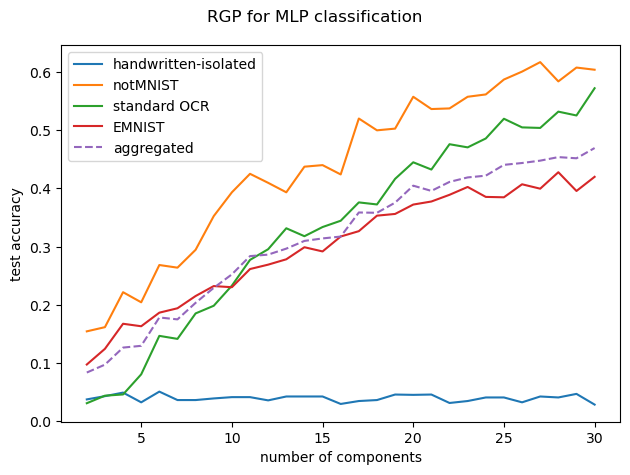

In [65]:
plot_scores(mlp_rgp_results, range(2, 31), title="RGP for MLP classification")

## MPCA

Code taken from https://github.com/tensorly/Proceedings_IEEE_companion_notebooks/blob/master/MPCA.ipynb

In [66]:
def compute_modek_total_scatter(X, mode, factors):
    scatter = 0
    
    for m in range(len(X)):
        proj_but_k = tl.unfold(tl.tenalg.multi_mode_dot(X[m], factors, transpose=True, skip=mode), mode)
        scatter += tl.dot(proj_but_k, proj_but_k.T)
        
    return scatter

def MPCA(X, rank, niters=1, size=28):
    X = tl.tensor(X.reshape(-1, size, size).astype(float))
    Xmean = tl.mean(X, axis=0)
    X = X - Xmean
    factors = [tl.ones((dim, rank)) for dim in X.shape[1:]]

    num_modes = len(X.shape) - 1
    niters = niters

    for _ in range(niters):
        for k in range(num_modes):
            scatter = compute_modek_total_scatter(X, k, factors)
            U, _, _ = tl.tenalg.svd_interface(scatter, n_eigenvecs=rank)
            factors[k] = U

    def _MCPA_func(X):
        X = tl.tensor(X.reshape(-1, size, size).astype(float))
        X = X - Xmean
        res = tl.tenalg.multi_mode_dot(X, factors, modes=[1, 2], transpose=True)
        return res
    return _MCPA_func

# need this wrapper because defining lambdas in for loops just doesn't
# work like intended
def _get_flatten_mpca_func(mpca, rank):
    return lambda x: mpca(x).reshape(-1, rank ** 2)

allranks = list(range(4, 26))
allmpcas = [MPCA(cons_train_data, i, niters=1, size=28) for i in allranks]
mpcatrf_funcs = [_get_flatten_mpca_func(mpca, allranks[i]) for i, mpca in enumerate(allmpcas)]

### KNN

In [ ]:
knn_mpca_results = test_trf_models(create_knn, mpcatrf_funcs, 4, 25)

n_components: 4
KNN training took: 0.49823904037475586 sec.

Model testing took: 0.5043871402740479 sec.

handwritten-isolated score: 0.47544642857142855
notMNIST score: 0.8004807692307693
standard OCR score: 0.8562014591668627
EMNIST score: 0.6661184210526315
Aggregate score: 0.7416764132553606
------
n_components: 5
KNN training took: 0.47594523429870605 sec.

Model testing took: 0.5813019275665283 sec.

handwritten-isolated score: 0.5200892857142857
notMNIST score: 0.8167735042735043
standard OCR score: 0.8912685337726524
EMNIST score: 0.6996710526315789
Aggregate score: 0.7722417153996102
------
n_components: 6
KNN training took: 0.47665882110595703 sec.

Model testing took: 0.6457507610321045 sec.

handwritten-isolated score: 0.5334821428571429
notMNIST score: 0.8218482905982906
standard OCR score: 0.9042127559425748
EMNIST score: 0.7460526315789474
Aggregate score: 0.7908771929824562
------
n_components: 7
KNN training took: 0.47225069999694824 sec.

Model testing took: 0.7404131

In [ ]:
np.max(knn_mpca_results["aggscores"])

0.8037426900584795

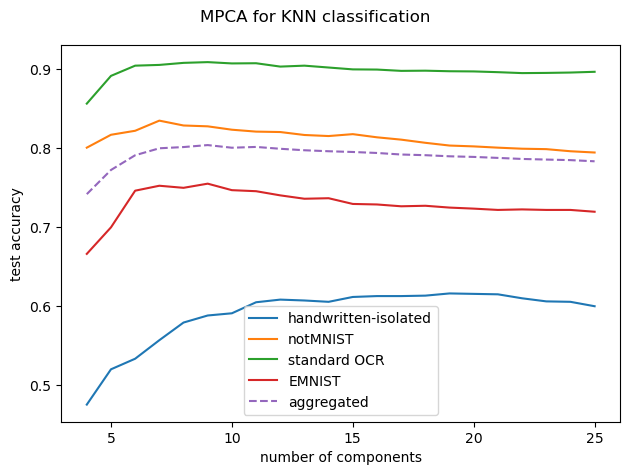

In [ ]:
plot_scores(knn_mpca_results, range(4, 26), title="MPCA for KNN classification")

### SVM

In [67]:
svm_mpca_results = test_trf_models(create_svm, mpcatrf_funcs[0:17], 4, 20)

n_components: 4
SVM training took: 81.73423194885254 sec.

Model testing took: 60.00213980674744 sec.

handwritten-isolated score: 0.10267857142857142
notMNIST score: 0.8199786324786325
standard OCR score: 0.8096022593551424
EMNIST score: 0.5980263157894737
Aggregate score: 0.6637037037037037
------
n_components: 5
SVM training took: 97.7191014289856 sec.

Model testing took: 59.96769714355469 sec.

handwritten-isolated score: 0.10044642857142858
notMNIST score: 0.843482905982906
standard OCR score: 0.8780889621087314
EMNIST score: 0.6513157894736842
Aggregate score: 0.7055750487329435
------
n_components: 6
SVM training took: 99.62028956413269 sec.

Model testing took: 61.43325757980347 sec.

handwritten-isolated score: 0.10714285714285714
notMNIST score: 0.8522970085470085
standard OCR score: 0.9136267357025183
EMNIST score: 0.7029605263157894
Aggregate score: 0.7330994152046784
------
n_components: 7
SVM training took: 114.38226556777954 sec.

Model testing took: 64.55795574188232 s

In [68]:
np.max(svm_mpca_results['aggscores'])

0.7506432748538012

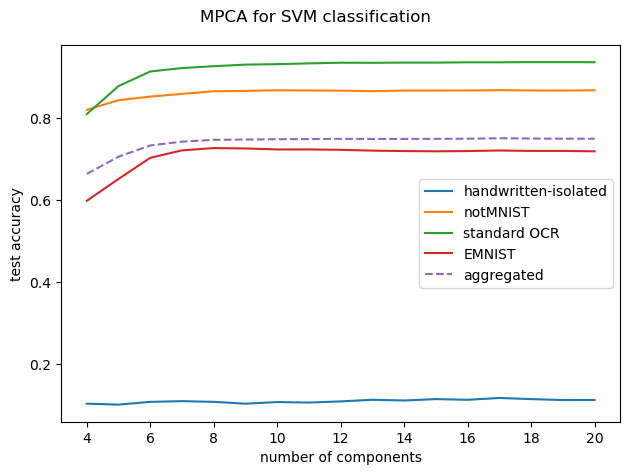

In [69]:
plot_scores(svm_mpca_results,range(4,21),title='MPCA for SVM classification')

### MLP

In [70]:
mlp_mpca_results = test_trf_models(create_mlp, mpcatrf_funcs[0:17],4, 20)

n_components: 4
MLP training took: 97.66992545127869 sec.

Model testing took: 0.20516419410705566 sec.

handwritten-isolated score: 0.06361607142857142
notMNIST score: 0.7152777777777778
standard OCR score: 0.7863026594492822
EMNIST score: 0.5457236842105263
Aggregate score: 0.6075633528265107
------
n_components: 5
MLP training took: 91.1438364982605 sec.

Model testing took: 0.18420195579528809 sec.

handwritten-isolated score: 0.07310267857142858
notMNIST score: 0.7649572649572649
standard OCR score: 0.8032478230171806
EMNIST score: 0.5898026315789474
Aggregate score: 0.6394541910331384
------
n_components: 6
MLP training took: 83.20942687988281 sec.

Model testing took: 0.21573686599731445 sec.

handwritten-isolated score: 0.09654017857142858
notMNIST score: 0.7652243589743589
standard OCR score: 0.851494469286891
EMNIST score: 0.6177631578947368
Aggregate score: 0.6654191033138401
------
n_components: 7
MLP training took: 70.24697804450989 sec.

Model testing took: 0.271932125091

In [71]:
np.max(mlp_mpca_results['aggscores'])

0.687485380116959

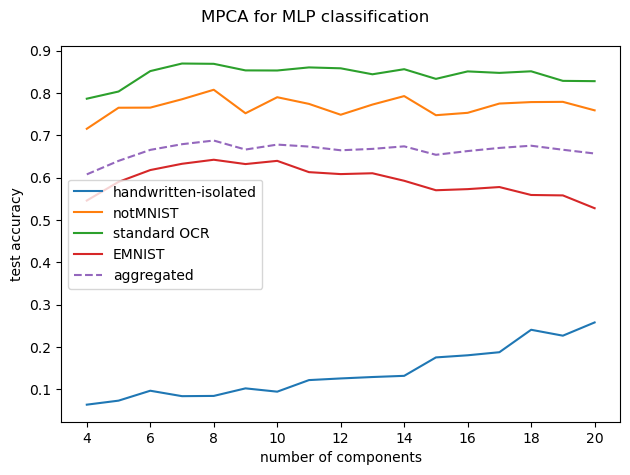

In [73]:
plot_scores(mlp_mpca_results, range(4,21),title='MPCA for MLP classification')

testing stuff here

In [ ]:
X = tl.tensor(notmnist_test_data.reshape(-1, 28, 28).astype(float))
Xmean = tl.mean(X, axis=0)
Xcent = X - Xmean

In [ ]:
mcpa = MPCA(X, 10)

In [ ]:
asdf = mcpa(X)

(3744, 10, 10)


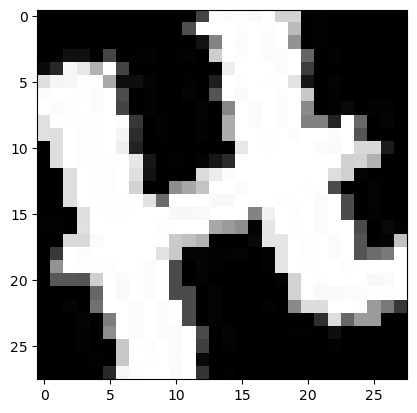

In [ ]:
plt.imshow(X[0], cmap="gray")

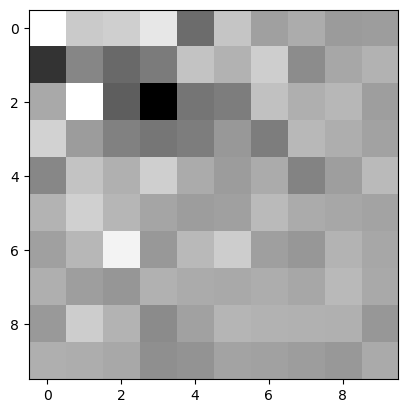

In [ ]:
plt.imshow(asdf[0], cmap="gray")

## CNN tests

TODO these need to be done a datahub or someones laptop will explode

In [ ]:
# remake these datasets with a new transform to keep them as a tensor

# this dataset is already random rotated
handiso_ds_train = utils.CharDataset("data/handwritten-isolated-english/train", transform=utils.T_tensor, label_transform=utils.class_to_idx)
handiso_ds_test = utils.CharDataset("data/handwritten-isolated-english/test", transform=utils.T_tensor, label_transform=utils.class_to_idx)

notmnist_ds = utils.CharDataset("data/notMNIST_small", transform=utils.T_randrottensor, label_transform=utils.class_to_idx)
notmnist_ds_train, notmnist_ds_test = random_split(notmnist_ds, [0.8, 0.2])

stdocr_ds_train_orig = (
    utils.CharDataset("data/standard_ocr_dataset/data/training_data", transform=utils.T_randrottensor, label_transform=utils.class_to_idx) +
    utils.CharDataset("data/standard_ocr_dataset/data2/training_data", transform=utils.T_randrottensor, label_transform=utils.class_to_idx)
)
stdocr_ds_test = (
    utils.CharDataset("data/standard_ocr_dataset/data/testing_data", transform=utils.T_randrottensor, label_transform=utils.class_to_idx) +
    utils.CharDataset("data/standard_ocr_dataset/data2/testing_data", transform=utils.T_randrottensor, label_transform=utils.class_to_idx)
)

mnist_ds_train_letters = EMNIST(Path(os.getcwd(), "data"), "letters", download=True, train=True, transform=utils.T_randrottensor, target_transform=utils.emnistletter_idx_to_allidx)
mnist_ds_train_digits = EMNIST(Path(os.getcwd(), "data"), "digits", download=True, train=True, transform=utils.T_randrottensor)
mnist_ds_train_orig = mnist_ds_train_letters + mnist_ds_train_digits
mnist_ds_test_letters = EMNIST(Path(os.getcwd(), "data"), "letters", download=True, train=False, transform=utils.T_randrottensor, target_transform=utils.emnistletter_idx_to_allidx)
mnist_ds_test_digits = EMNIST(Path(os.getcwd(), "data"), "digits", download=True, train=False, transform=utils.T_randrottensor)
mnist_ds_test_orig = mnist_ds_test_letters + mnist_ds_test_digits

stdocr_ds_train, _ = random_split(stdocr_ds_train_orig, [0.5, 0.5])
mnist_ds_train, _ = random_split(mnist_ds_train_orig, [0.05, 0.95])
mnist_ds_test, _ = random_split(mnist_ds_test_orig, [0.05, 0.95])

consolidated_ds_train = handiso_ds_train + notmnist_ds_train + stdocr_ds_train + mnist_ds_train
consolidated_ds_test = handiso_ds_test + notmnist_ds_test + stdocr_ds_test + mnist_ds_test

In [ ]:
trainloader = torch.utils.data.DataLoader(consolidated_ds_train, num_workers=31, batch_size=32)
testloader = torch.utils.data.DataLoader(consolidated_ds_test, num_workers=31, batch_size=32)

In [ ]:
genCNN = utils.GenericCharCNN()
trainer = L.Trainer(max_epochs=30)
trainer.fit(model=genCNN, train_dataloaders=trainloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 156   
1 | pool  | MaxPool2d | 0     
2 | conv2 | Conv2d    | 2.4 K 
3 | fc1   | Linear    | 30.8 K
4 | fc2   | Linear    | 10.2 K
5 | fc3   | Linear    | 3.1 K 
------------------------------------
46.6 K    Trainable params
0         Non-trainable params
46.6 K    Total params
0.187     Total estimated model params size (MB)


Epoch 3:   0%|          | 0/2095 [00:00<?, ?it/s, v_num=1]           

Exception ignored in: <function _releaseLock at 0x7f5a1ff2cb80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


In [ ]:
trainer.test(genCNN, dataloaders=testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 401/401 [00:21<00:00, 18.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.05871345102787018
        test_loss            4.275759696960449
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 4.275759696960449, 'test_acc': 0.05871345102787018}]